# The testing notebook to see if I can try and predict the price of microsoft

Using an lstm and 1 years worth of microsoft data, we'll try and predict what the stock will do

In [9]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np

In [10]:
df = pd.read_csv('data/MSFT.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-12-02,330.299988,333.489990,327.799988,329.489990,326.431274,30766000
1,2021-12-03,331.989990,332.700012,318.029999,323.010010,320.011444,41779300
2,2021-12-06,323.950012,327.450012,319.230011,326.190002,323.161896,30032600
3,2021-12-07,331.640015,335.799988,330.100006,334.920013,331.810883,31021900
4,2021-12-08,335.309998,335.500000,330.799988,334.970001,331.860413,24761000
...,...,...,...,...,...,...,...
247,2022-11-25,247.309998,248.699997,246.729996,247.490005,247.490005,9200800
248,2022-11-28,246.080002,246.649994,240.800003,241.759995,241.759995,24778200
249,2022-11-29,241.399994,242.789993,238.210007,240.330002,240.330002,17956300
250,2022-11-30,240.570007,255.330002,239.860001,255.139999,255.139999,47594200


We just want the closing price for now because we're only using one inputf

In [11]:
df = df[['Date', 'Close']]
df

,Date,Close
0,2021-12-02,329.489990
1,2021-12-03,323.010010
2,2021-12-06,326.190002
3,2021-12-07,334.920013
4,2021-12-08,334.970001
...,...,...
247,2022-11-25,247.490005
248,2022-11-28,241.759995
249,2022-11-29,240.330002
250,2022-11-30,255.139999


A function to convert the strings to datetime objects in the df

In [12]:
def strToDatetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

df['Date'] = df['Date'].apply(strToDatetime)
# create the date the index

df.index = df.pop('Date')
df

C:\Users\will\AppData\Local\Temp\ipykernel_88496\3723675339.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(strToDatetime)


,Close
Date,
2021-12-02,329.489990
2021-12-03,323.010010
2021-12-06,326.190002
2021-12-07,334.920013
2021-12-08,334.970001
...,...
2022-11-25,247.490005
2022-11-28,241.759995
2022-11-29,240.330002


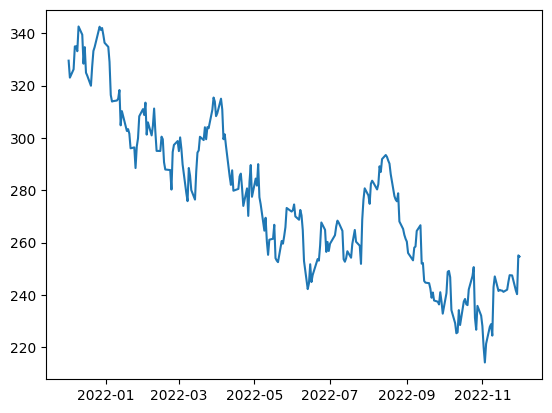

In [13]:
plt.plot(df.index, df['Close'])

Big function to partion the data to get ready for training

In [14]:
def dfToWindowedDf(dataframe, first_date_str, last_date_str, n=3):
    first_date = strToDatetime(first_date_str)
    last_date  = strToDatetime(last_date_str)

    target_date = first_date

    dates = []
    X, Y = [], []

    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(n+1)

        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return

        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

        if last_time:
            break

        target_date = next_date

        if target_date == last_date:
            last_time = True

    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates

    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_df[f'Target-{n-i}'] = X[:, i]

    ret_df['Target'] = Y

    return ret_df

# Start day second time around: '2021-03-25'
windowed_df = dfToWindowedDf(df, 
                                '2021-12-07', 
                                '2022-11-30', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-12-07,329.489990,323.010010,326.190002,334.920013
1,2021-12-08,323.010010,326.190002,334.920013,334.970001
2,2021-12-09,326.190002,334.920013,334.970001,333.100006
3,2021-12-10,334.920013,334.970001,333.100006,342.540009
4,2021-12-13,334.970001,333.100006,342.540009,339.399994
...,...,...,...,...,...
243,2022-11-23,241.220001,242.050003,245.029999,247.580002
244,2022-11-25,242.050003,245.029999,247.580002,247.490005
245,2022-11-28,245.029999,247.580002,247.490005,241.759995
246,2022-11-29,247.580002,247.490005,241.759995,240.330002


In [7]:
def windowedDfToDateX_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()

    dates = df_as_np[:, 0]

    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

    Y = df_as_np[:, -1]

    return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowedDfToDateX_y(windowed_df)

dates.shape, X.shape, y.shape

((248,), (248, 3, 1), (248,))

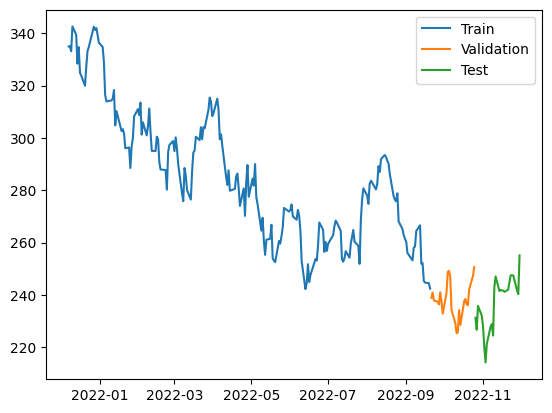

In [8]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
7/7 [==============================] - 3s 88ms/step - loss: 81745.0234 - mean_absolute_error: 284.8143 - val_loss: 56392.1133 - val_mean_absolute_error: 237.3736
Epoch 2/100
7/7 [==============================] - 0s 6ms/step - loss: 81432.5078 - mean_absolute_error: 284.2658 - val_loss: 56133.0156 - val_mean_absolute_error: 236.8272
Epoch 3/100
7/7 [==============================] - 0s 6ms/step - loss: 81122.1406 - mean_absolute_error: 283.7178 - val_loss: 55866.1406 - val_mean_absolute_error: 236.2631
Epoch 4/100
7/7 [==============================] - 0s 8ms/step - loss: 80783.5938 - mean_absolute_error: 283.1217 - val_loss: 55536.8203 - val_mean_absolute_error: 235.5651
Epoch 5/100
7/7 [==============================] - 0s 13ms/step - loss: 80350.2422 - mean_absolute_error: 282.3525 - val_loss: 55072.5039 - val_mean_absolute_error: 234.5774
Epoch 6/100
7/7 [==============================] - 0s 9ms/step - loss: 79713.3672 - mean_absolute_error: 281.2213 - val_loss: 54335.4

7/7 [==============================] - 0s 1ms/step


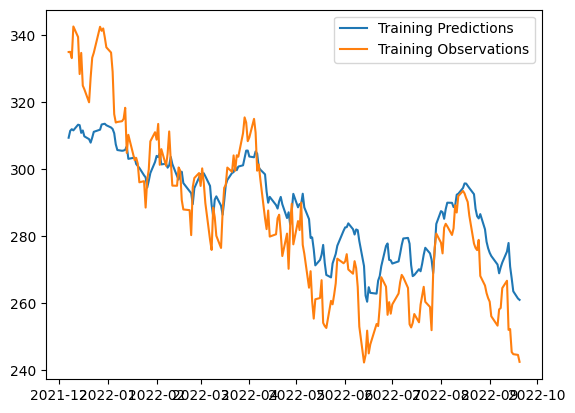

In [10]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 [==============================] - 0s 17ms/step


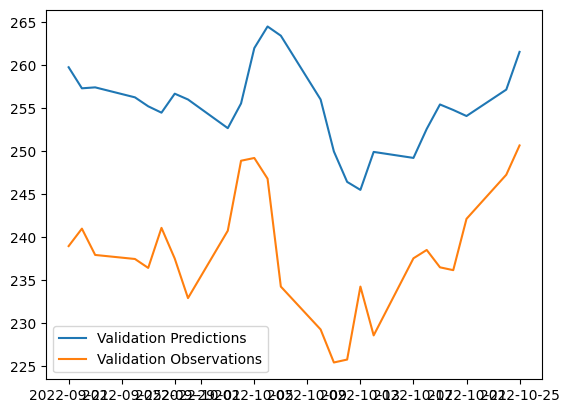

In [11]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 [==============================] - 0s 18ms/step


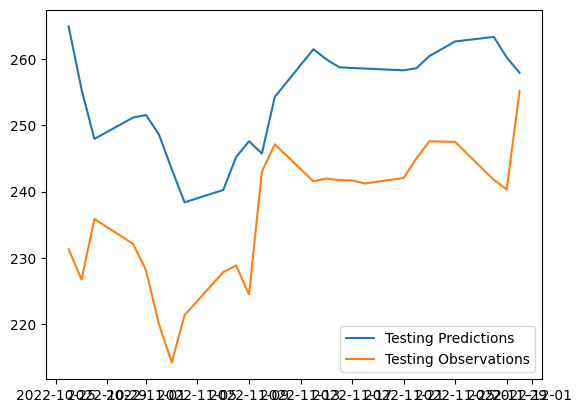

In [12]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

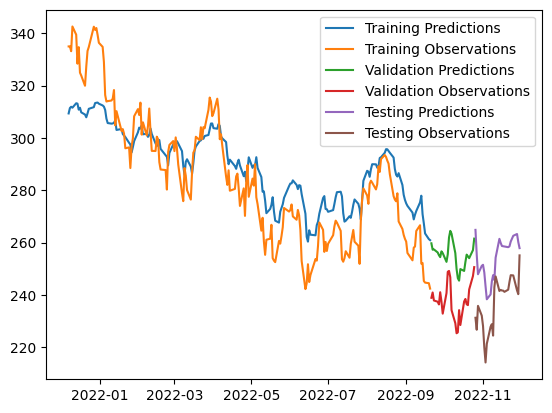

In [13]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [14]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

last_window = deepcopy(X_train[-1])

for target_date in recursive_dates:
    next_prediction = model.predict(np.array([last_window])).flatten()
    recursive_predictions.append(next_prediction)
    last_window[-1] = next_prediction

1/1 [==============================] - 0s 17ms/step


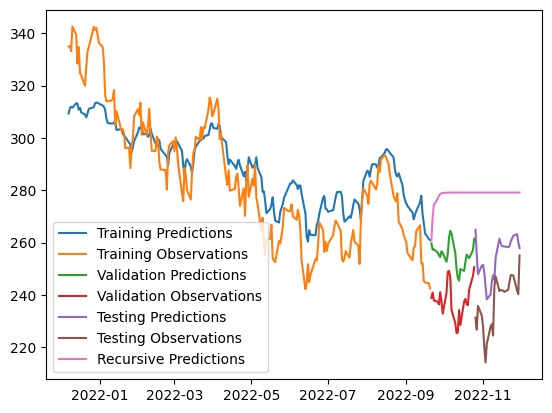

In [15]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])

**So from this we can see that using a recursive option to predicit the future isn't going to be sucessful as the predictions will just converge to a change of 0, what about just predicting what is going to happen the next day? If we can try and predict the next day over the course of the testing set and see if 1) the prediction was correct (the prediction follwed the actual data by going up or down). 2) by how much the prediction was right or wrong.**

In [16]:
test_predictions

array([264.87933, 255.41454, 247.933  , 251.15468, 251.5446 , 248.64366,
       243.38864, 238.3772 , 240.24246, 245.19983, 247.58449, 245.73398,
       254.2657 , 261.4518 , 259.9315 , 258.7366 , 258.62344, 258.53912,
       258.27295, 258.59552, 260.42178, 262.62027, 263.30798, 260.22665,
       257.91452], dtype=float32)

In [17]:
dates_test_list = dates_test
actual_test_vals = df[df.index.isin(dates_test_list)]
actual_test_vals = actual_test_vals.rename(columns={'Close': 'Close Actual'})
actual_test_vals['Close Prediction'] = test_predictions
actual_test_vals

,Close Actual,Close Prediction
Date,,
2022-10-26,231.320007,264.879333
2022-10-27,226.750000,255.414536
2022-10-28,235.869995,247.932999
2022-10-31,232.130005,251.154678
2022-11-01,228.169998,251.544601
2022-11-02,220.100006,248.643661
2022-11-03,214.250000,243.388641
2022-11-04,221.389999,238.377197
2022-11-07,227.869995,240.242462


In [18]:
close_actual_list = actual_test_vals['Close Actual'].to_list()
close_pred_list = actual_test_vals['Close Prediction'].to_list()
correct_pred_list = [None]
for index, (actual, pred) in enumerate(zip(close_actual_list, close_pred_list)):
    if index != 0:
        actual_up = actual > close_actual_list[index-1]
        pred_up = pred > close_actual_list[index-1]
        
        correct_pred_list.append(actual_up == pred_up)
print('percentage of correct guesses')
print( len([x for x in correct_pred_list if x == True]) / (len(correct_pred_list)-1) *100)
actual_test_vals['Correct Prediction'] = correct_pred_list
actual_test_vals

percentage of correct guesses
45.83333333333333


,Close Actual,Close Prediction,Correct Prediction
Date,,,
2022-10-26,231.320007,264.879333,None
2022-10-27,226.750000,255.414536,False
2022-10-28,235.869995,247.932999,True
2022-10-31,232.130005,251.154678,False
2022-11-01,228.169998,251.544601,False
2022-11-02,220.100006,248.643661,False
2022-11-03,214.250000,243.388641,False
2022-11-04,221.389999,238.377197,True
2022-11-07,227.869995,240.242462,True


In [19]:
df

,Close
Date,
2021-12-02,329.489990
2021-12-03,323.010010
2021-12-06,326.190002
2021-12-07,334.920013
2021-12-08,334.970001
...,...
2022-11-25,247.490005
2022-11-28,241.759995
2022-11-29,240.330002
